In [1]:
%matplotlib inline
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set()
except ImportError:
    pass

import torch
from torch.autograd import Variable

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101)

In [2]:
def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.Tensor([0.75])))

In [3]:
posterior = pyro.infer.Importance(scale, num_samples=100)


In [4]:
guess = Variable(torch.Tensor([8.5]))

marginal = pyro.infer.Marginal(posterior)
print(marginal(guess))


Variable containing:
 10.0699
[torch.FloatTensor of size 1]



Text(0,0.5,'#')

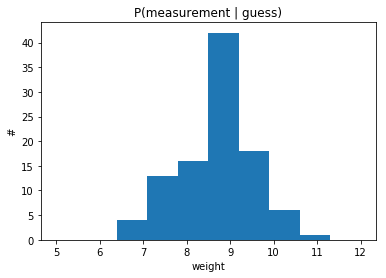

In [5]:
plt.hist([marginal(guess).data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#")

In [6]:
conditioned_scale = pyro.condition(
    scale, data={"measurement": Variable(torch.Tensor([8.5]))})


In [7]:
# equivalent to pyro.condition(scale, data={"measurement": Variable(torch.ones(1))})
def scale_obs(guess):
    z = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
     # here we attach an observation measurement == 1
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.ones(1)),
                       obs=Variable(torch.Tensor([0.1])))

# equivalent to scale_obs:
def scale_obs(guess):
    z = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # here we attach an observation measurement == 1
    return pyro.observe("measurement", dist.normal, Variable(torch.ones(1)),
                        weight, Variable(torch.Tensor([0.1])))


In [8]:
def scale2(guess):
    weight = pyro.sample("weight", dist.normal,
                         guess, Variable(torch.ones(1)))
    tolerance = torch.abs(
        pyro.sample("tolerance", dist.normal, Variable(torch.zeros(1)), Variable(torch.ones(1))))

    return pyro.sample("measurement", dist.normal, weight, tolerance)

# conditioning composes:
# the following are all equivalent and do not interfere with each other
conditioned_scale2_1 = pyro.condition(
    pyro.condition(scale2, data={"weight": Variable(torch.ones(1))}),
    data={"measurement": Variable(torch.ones(1))})

conditioned_scale2_2 = pyro.condition(
    pyro.condition(scale2, data={"measurement": Variable(torch.ones(1))}),
    data={"weight": Variable(torch.ones(1))})

conditioned_scale2_3 = pyro.condition(
    scale2, data={"weight": Variable(torch.ones(1)), "measurement": Variable(torch.ones(1))})
